In [1]:
#Downloading all the libraries
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import tensorflow
import random
import numpy

In [2]:
# Downloading the dataset
!echo "Downloading lFW dataset"
!curl -L -o lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xzf lfw.tgz
!rm lfw.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  12.9M      0  0:00:13  0:00:13 --:--:-- 15.5M


In [ ]:
# ResNet50 model
import tensorflow
model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=True)

In [ ]:
# Checking the layers in model
model.summary()

In [5]:
# Converting the image into numpy array
import numpy as np
import matplotlib.pyplot as plt

def image_numpy(path):
    image1 = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(image1)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return image1, img

shape of x:  (1, 224, 224, 3)
data type:  float32


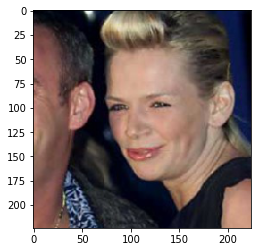

In [6]:
# Storing the shape of images 
image1, img = image_numpy("lfw/Zoe_Ball/Zoe_Ball_0001.jpg")
print("shape of x: ", img.shape)
print("data type: ", img.dtype)
plt.imshow(image1)

In [7]:
# model. predict() : given a trained model, predict the label of a new set of data
labels = model.predict(x)

NameError: ignored

In [ ]:
labels = model(x)  # converts into  a tensorflow object
labels = labels.numpy()   # COnverts that tensorflow object into numpy array

In [8]:
# Removing the last "predictions" layer from the model
feature_array = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feature_array.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
# Path of images in google colab
PathOfImage = 'lfw'
extension = ['.jpg', '.png', '.jpeg']  

In [10]:
images_arr = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PathOfImage) for f in filenames if os.path.splitext(f)[1].lower() in extension]

In [ ]:
#images = images[1:301]
print(len(images_arr))
#images_arr = images_arr[1:51]

13233


In [17]:
pip install utils

In [ ]:
features = []
for i, PathOfImage in enumerate(images_arr):
    if i % 500 == 0:
        print("analyzing image %d: " % (i))
    image1, img = image_numpy(PathOfImage);
    j = feature_array.predict(img)[0]
    features.append(j)

print('finished extracting features for total images: ', len(images_arr))

analyzing image 0: 
analyzing image 500: 
analyzing image 1000: 
analyzing image 1500: 
analyzing image 2000: 
analyzing image 2500: 
analyzing image 3000: 
analyzing image 3500: 
analyzing image 4000: 
analyzing image 4500: 
analyzing image 5000: 


In [25]:
def neighbours(input_image):
    euclid_distances = [ distance.euclidean(features[input_image], j) for j in features ]
    nn = sorted(range(len(euclid_distances)), key=lambda k: euclid_distances[k])
    nn = nn[1:6]
    return nn

def output_nn(indexes, result_img_height):
    result_img = []
    for i in indexes:
        image1 = image.load_img(images_arr[i])
        image1 = image1.resize((int(image1.width * result_img_height / image1.height), result_img_height))
        result_img.append(image1)
    concat_image = np.concatenate([np.asarray(i) for i in result_img], axis=1)
    return concat_image

In [23]:
# do a query on a random image
from scipy.spatial import distance
input_image = int(len(images_arr) * random.random())
nn = neighbours(input_image)
Input_images = output_nn([input_image], 300)
result_array = output_nn(nn, 200)

# display the query image
plt.figure(figsize = (5,10))
plt.imshow(Input_images)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (15,15))
plt.imshow(result_array)
plt.title("result images")

ValueError: ignored

Text(0.5, 1.0, 'result images')

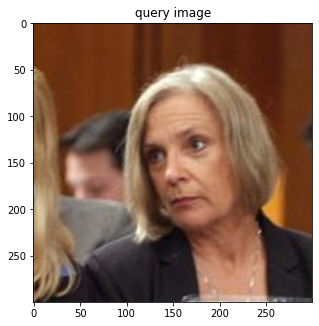

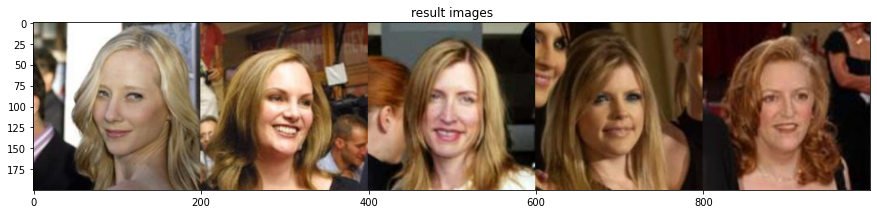

In [ ]:
# do a query on a random image
from scipy.spatial import distance
input_image = int(len(images_arr) * 0.70998)
nn = neighbours(input_image)
Input_images = output_nn([input_image], 300)
result_array = output_nn(nn, 200)

# display the query image
plt.figure(figsize = (5,10))
plt.imshow(Input_images)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (15,15))
plt.imshow(result_array)
plt.title("result images")

In [ ]:
def reverse_image_search(img, output_size=6):
  nn = neighbours(input_image)
  Input_images = output_nn([input_image], 300)
  result_array = output_nn(nn, 200)

  # display the query image
  plt.figure(figsize = (5,10))
  plt.imshow(Input_images)
  plt.title("query image")

  # display the resulting images
  plt.figure(figsize = (15,15))
  plt.imshow(result_array)
  plt.title("result images")

  return result_array